# Two chargers stochastic simulation

* Vehicles arrive at rate $\lambda$ uniformly distributed in [0,1].
* There are two chargers C1 and C2 with infinite capacity.
* Vehicles require a charging time $\exp(\mu)$ after which they depart.
* Initially, they choose the nearest charger.

In [51]:
using Distributions, Plots

#Objeto que representa al cargador.
mutable struct Charger
    position::Float64
    currentOccupation::Integer
    currentPrice::Float64
    Charger(position::Float64) = new(position,0,0.0)
end

#Objeto que representa al EV
mutable struct EV
    arrivalTime::Float64
    arrivalPosition::Float64
    requiredEnergy::Float64
    assignedCharger::Union{Charger,Nothing}
    departureTime::Float64
    EV(arrivalTime::Float64,arrivalPosition::Float64,requiredEnergy::Float64) = new(arrivalTime,arrivalPosition,requiredEnergy,nothing,NaN)
end

#auxiliar
function compute_distance(ev::EV,c::Charger)
    return abs(ev.arrivalPosition - c.position)
end

function update_energy!(ev::EV,dt::Float64)
    ev.requiredEnergy = ev.requiredEnergy-dt
end


update_energy! (generic function with 1 method)

In [52]:
lambda = 10.0 #autos por hora
mu=0.5   #2 horas de carga

Tfinal=10.0

c1 = Charger(0.25)
c2 = Charger(0.75)

chargers = [c1;c2]

EVs = EV[]   #lista de vehiculos en el sistema

finishedEVs = EV[] #lista de vehiculos que terminaron (para estadistica)

dist_arrivals = Exponential(1/lambda)   #hay que pasarle la media no el parámetro
dist_energy = Exponential(1/mu)   #hay que pasarle la media no el parámetro
dist_position = Uniform(0,1)

t=0.0
T=[t]

C1=[c1.currentOccupation]
C2=[c2.currentOccupation]

nextArr = rand(dist_arrivals)
nextDep = Inf
nextCarToFinish = nothing  #Esto apunta a un vehiculo del array EVs que es el de menor remanente

dt,caso = findmin([nextArr,nextDep])

while t<Tfinal
    
    t=t+dt
    nextArr=nextArr-dt
    #le descuento el servicio a todos
    map(ev->update_energy!(ev,dt),EVs)
    
    if caso==1 #arribo

       #creo un nuevo vehiculo
       new_ev = EV(t,rand(dist_position), rand(dist_energy))
       push!(EVs,new_ev)
       
       #calculo su cargador
       distancias = compute_distance.(Ref(new_ev), chargers)  #el Ref es para que el . opere solo sobre los chargers
       _,idx = findmin(distancias)
       
       #lo asigno
       new_ev.assignedCharger = chargers[idx]
       chargers[idx].currentOccupation = chargers[idx].currentOccupation+1
       
       #sorteo el proximo arribo
       nextArr = rand(dist_arrivals)

    elseif caso==2 #partida
        
        #lo guardo como terminado
        EVs[nextCarToFinish].departureTime = t
        push!(finishedEVs, EVs[nextCarToFinish])
        
        #le bajo la ocupacion al cargador
        EVs[nextCarToFinish].assignedCharger.currentOccupation = EVs[nextCarToFinish].assignedCharger.currentOccupation-1
        deleteat!(EVs,nextCarToFinish)
    end
    
    push!(T,t)
    push!(C1,c1.currentOccupation)
    push!(C2,c2.currentOccupation)

    if c1.currentOccupation+c2.currentOccupation>0
        nextDep,nextCarToFinish = findmin([ev.requiredEnergy for ev in EVs])
    else
        nextDep = Inf
        nextCarToFinish=nothing
    end
    
    dt,caso = findmin([nextArr,nextDep])
    
 end


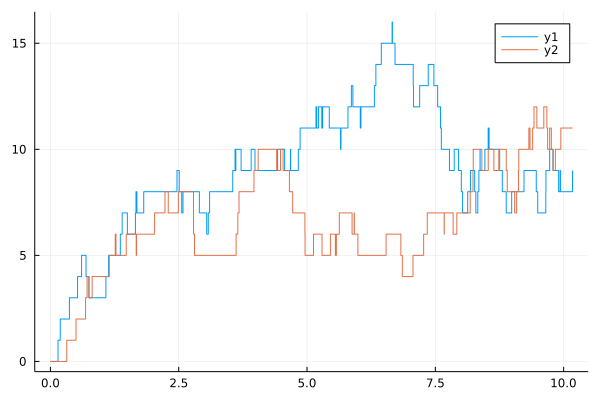

In [53]:
plot(T,C1,lt=:steppost)
plot!(T,C2,lt=:steppost)
